# Imaging Connectomics: A new insights for understanding brain diseases

Copyright 2018 Andrea Insabato, Mathieu Gilson

This code is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This notebook containes the code to reproduce figures of the book chapter "Imaging Connectomics: A new insights for understanding brain diseases".

The code is written in Python 3 and uses, beyond the typical suite of libraries for scientific computing (Scipy, Numpy, Matplotlib): NetworkX library to deal with networks, Scikit Learn for machine learning routines, Pandas and Seaborn for some graphical representations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
from scipy.stats import pearsonr, ttest_ind
from sklearn.covariance import GraphicalLassoCV
from conn_utils import make_chain, make_common_input, make_full, make_rnd_connectivity, MOU
sns.set_context('poster')
plt.rcParams['figure.figsize'] = (15, 8)
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Anscombe quartet

A recurrent discussion about connectivity measures is that about model-free versus model-based approaches. 

Our viewpoint is that, even though measures can be calculated without explicitly assuming a model, __their interpretation is always related to a model__.

To illustrate this point in a simple bivariate case we reproduce Anscombe's quartet, that shows assumptions underlying Pearson's correlation and their violations.

In all four panels the coefficient is the same but only the top left panel shows the distribution of data that we would expect if we are told that $\rho=0.816$.

Dataset I has gaussian variables with linear dependence. Dataset II shows non linear dependence between y and x. Dataset III has a perfect linear relation but the estimates are off because of the presence of one outlier in the dependent variable. Dataset IV shows no relation between x and y but an apparently strong regression line due to one outlier in both the dependent and independent variable.


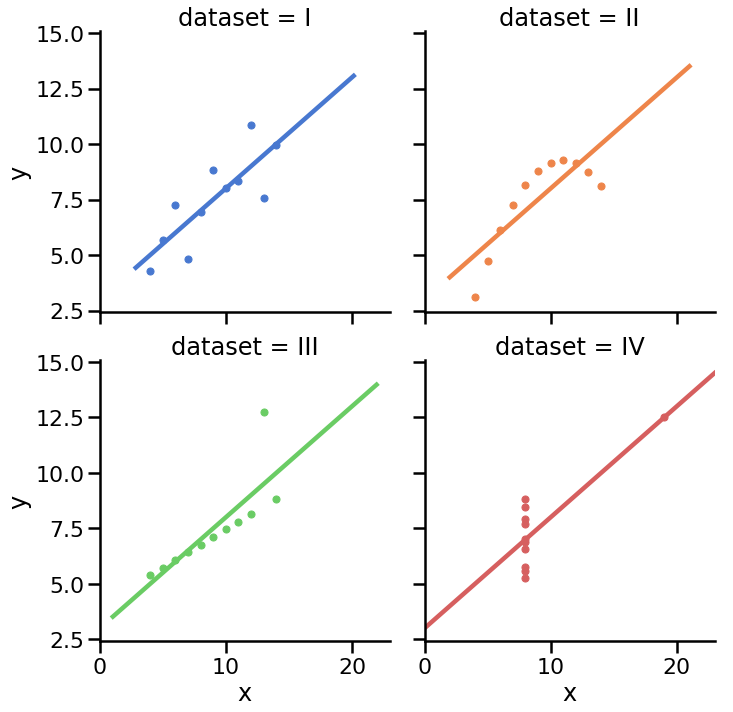

In [3]:
anscombe = sns.load_dataset('anscombe')
sns.lmplot(x="x", y="y", col="dataset", hue="dataset", data=anscombe,
           col_wrap=2, ci=None, palette="muted", scatter_kws={"s": 50, "alpha": 1})
plt.savefig('../chapter/figures/anscombe.eps')
plt.show()

## Causal and non-causal interactions

Minimal requirements for an interpretation of EC in terms of causality are directionality and sparseness of the connectivity (which are not necessarily fulfilled by every model). 
Without these requirements it’s impossible to identify different alternative configurations of the causal graph.

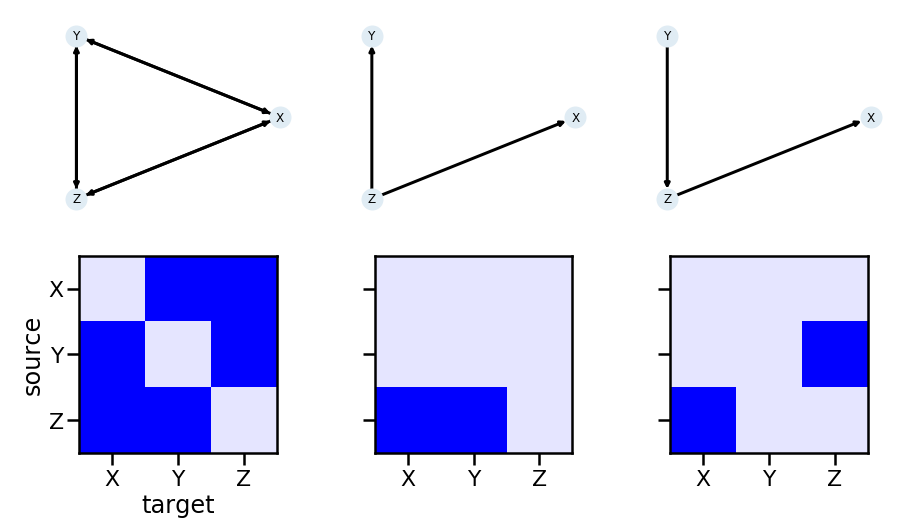

In [3]:
chain = make_chain()
common_drive = make_common_input()
full = make_full()

drawing_options = {
'node_color': '#e0ecf4',
'node_size': 400,
'width': 3,
}
colmap = sns.light_palette("blue", as_cmap=True)
plt.subplot(2, 3, 1)
nx.draw_circular(full, with_labels=True, **drawing_options)
plt.subplot(2, 3, 2)
nx.draw_circular(common_drive, with_labels=True, **drawing_options)
plt.subplot(2, 3, 3)
nx.draw_circular(chain, with_labels=True, **drawing_options)
plt.subplot(2, 3, 4)
plt.imshow(nx.to_numpy_matrix(full), cmap=colmap)
plt.yticks([0, 1, 2], ['X', 'Y', 'Z'])
plt.xticks([0, 1, 2], ['X', 'Y', 'Z'])
plt.ylabel('source')
plt.xlabel('target')
plt.subplot(2, 3, 5)
plt.imshow(nx.to_numpy_matrix(common_drive), cmap=colmap)
plt.yticks([0, 1, 2], [])
plt.xticks([0, 1, 2], ['X', 'Y', 'Z'])
plt.subplot(2, 3, 6)
plt.imshow(nx.to_numpy_matrix(chain), cmap=colmap)
plt.yticks([0, 1, 2], [])
plt.xticks([0, 1, 2], ['X', 'Y', 'Z'])
plt.savefig('../chapter/figures/directed_connectivity.pdf')
plt.show()

Three different graphs and their associated adjacency matrices. 
Left: fully connected graph. 
Center: Z is the common input to both X and Y. 
Right: chain from Y to X through Z. 

A connectivity measure unable to estimate a sparse matrix cannot distinguish the three cases: all estimates would look like the one on the left. A non-directed measure would be unable to distinguish between the chain and the common input: both estimated matrices would be symmetric.

## Estimation of connectivity with Pearson's correlation, partial correlation and MOU

Example of estimation of connectivity with different measure: full and undirected (Pearson's correlation), sparse and undirected (partial correlation), MOU (sparse and directed).

The data are generated with a MOU and a sparse and directed graph to highlight difference in retrieved estimates.
Pearson's correlation produce a symmetric and quite noisy estimate. Partial correlation has less noise but still introduces spurious links due to its undirected nature. MOU is able to retrieve a less noisy and non-symmetric estimate. Note, however the substantial error present in MOU estimate, due to finite samples in the generated time series (modeling error is zero in this case).

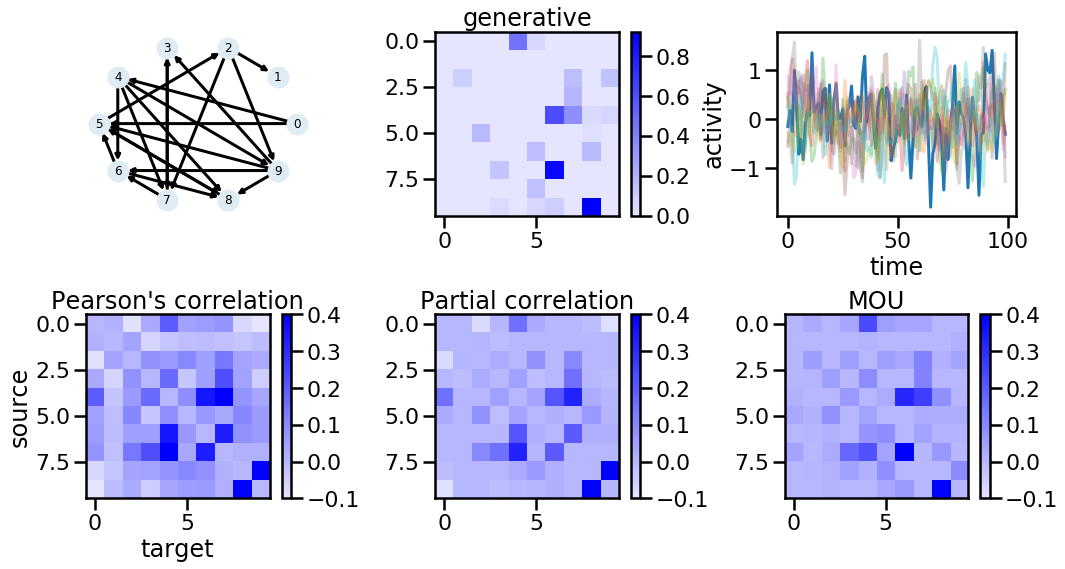

In [4]:
# generate connectivity matrix
plt.rcParams['figure.figsize'] = (15, 8)
n = 10
EC = make_rnd_connectivity(n=n)
G = nx.from_numpy_array(EC, create_using=nx.DiGraph())
plt.subplot(2,3,1)
nx.draw_circular(G, with_labels=True, **drawing_options)
plt.subplot(2,3,2)
plt.imshow(EC, cmap=colmap)
plt.colorbar()
plt.title('generative')
# generate data with MOU
generator = MOU(n_nodes=n, C=EC)
TS = generator.simulate(T=1000, random_state=0)
plt.subplot(2,3,3)
plt.plot(TS[:min(100, 1000), 0])
plt.plot(TS[:min(100, 1000), 1:], alpha=0.3)
plt.xlabel('time')
plt.ylabel('activity')
# estimate connectivity with Pearson's correlation, partial correlation, MOU
FC = np.corrcoef(TS.T)
np.fill_diagonal(FC, 0)
glasso = GraphicalLassoCV(cv=3)
glasso.fit(TS)
precision = glasso.precision_
prec_diag = np.diagonal(precision)
PC = - precision / np.sqrt(np.outer(prec_diag, prec_diag))
np.fill_diagonal(PC, 0)
mOU = MOU(n_nodes=n)
mOU.fit(TS)
C = mOU.C
plt.subplot(2,3,4)
plt.imshow(FC, cmap=colmap)
plt.colorbar()
plt.clim([-.1, .4])
plt.title('Pearson\'s correlation')
plt.xlabel('target')
plt.ylabel('source')
plt.subplot(2,3,5)
plt.imshow(PC, cmap=colmap)
plt.colorbar()
plt.clim([-.1, .4])
plt.title('Partial correlation')
plt.subplot(2,3,6)
plt.imshow(C, cmap=colmap)
plt.colorbar()
plt.clim([-.1, .4])
plt.title('MOU')
plt.tight_layout()
plt.savefig('../chapter/figures/estimation.pdf')
plt.show()

## Sliding window dynamic FC

Work in progress...

## P-value for increasing sample size

A common problem of NHT is the prevalent focus on p-values and the relative neglect of effect size.

An important concern about p-values is that every effect, even the tiniest, can be regarded as significant with a large enough sample size. This is shown in the figure below.

A related problem with p-values comes when a statistical test is repeated several times, for example to test if there is a difference between a treatment and control group for each connection in a FC. This process leads to the well known problem of multiple hypotheses testing. In NHT the p-value corresponds to the probability of a false positive results, or type I error. If we consider as significant all results where p<α, over m hypotheses the probability of making one or more false discoveries is 1-(1- α)m (for m=100 hypotheses and usual α=0.05, the probability of at least one false discovery is more than 0.99).

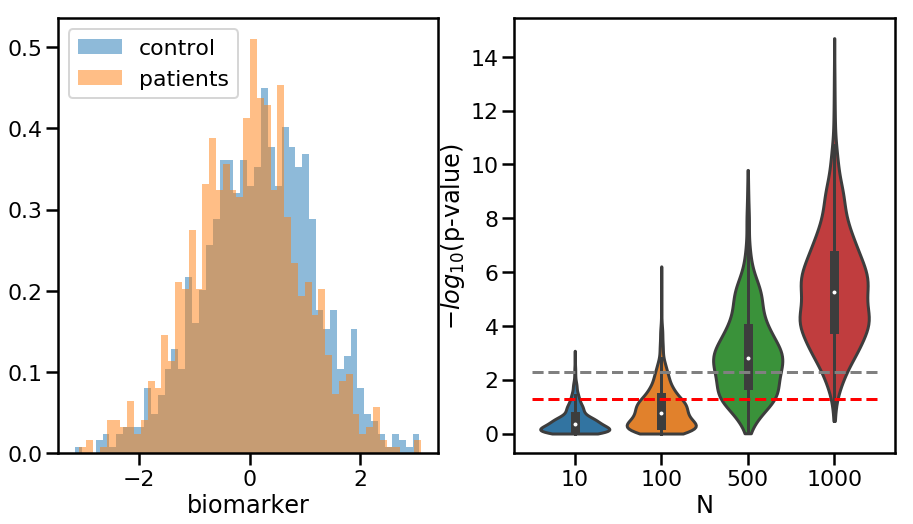

In [11]:
# show dependence of p-value on N
M = 1000
Ns = [10, 100, 500, 1000]
rej = np.zeros(len(Ns), dtype=int)
pvals = np.zeros([len(Ns), M])
for i, n in enumerate(Ns):
    for m in range(M):
        d = .2  # distance between means
        s = [1, 1]  # std
        N = [n, n]
        # sample group 0 from normal
        a = np.random.randn(N[0], 1) * s[0] + d
        # sample group 1 from normal
        b = np.random.randn(N[1], 1) * s[1]
    
        pvals[i, m] = ttest_ind(a, b)[1]
        
           
pvalsDF = pd.DataFrame({'p-value': -np.log10(pvals.T.flatten())})
pvalsDF["N"] = Ns * M
plt.figure()
ax = plt.subplot(1, 2, 2)
sns.violinplot(x="N", y='p-value', data=pvalsDF, cut=0, orient='v', scale='width')
xlims = plt.xlim()
plt.plot(xlims, [-np.log10(0.05), -np.log10(0.05)], '--r')
plt.plot(xlims, [-np.log10(0.005), -np.log10(0.005)], '--', color='grey')
plt.ylabel(r"$-log_{10}$(p-value)")
plt.subplot(1, 2, 1)
plt.hist(a, bins=50, alpha=0.5, normed=True, label="control")
plt.hist(b, bins=50, alpha=0.5, normed=True, label="patients")
plt.xlabel("biomarker")
plt.legend()
plt.savefig('../chapter/figures/p-value.pdf')

Simulated data from two groups: control and patients. Data are simulated drawing samples from two Gaussian with unitary variance and a difference in means of 0.2. Left: histogram with 1000 samples for each group; the difference is perceptible but the overlap is considerable. Right: distribution of log10(p-value) for different number of samples; transformation is used to make clear the whole range of values. Typical threshold of 0.05 and 0.005 are shown in red and gray respectively. For small sample size (10, 100) the effect is almost never detected, while for 1000 samples it is almost always detected.

## Univariate VS Multivariate

FC or EC are composed of a large number of connections. For example, Pearson’s correlation matrix of 100 brain regions has 4950 entries. 
So, each connectome is as a sample point in a space with very high dimensionality. 

The problem of testing for differences in this space with thousands of dimensions can be decomposed in principle into many univariate test, one for each dimension. Once the appropriate multiple tests controlling procedure is applied, there is nothing wrong in principle with this approach, in particular if the dimensions of the data are independent. 

However univariate analysis can miss some information if there is correlation between dimensions. This is shown in the following figure, where the marginal distribution of each dimension shows a considerable overlap for the two conditions, while they are perfectly separated in the 2D space.

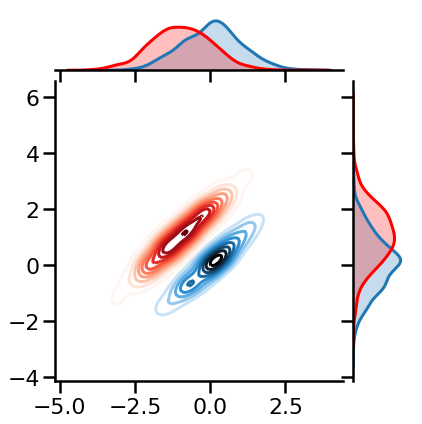

In [5]:
#%%  Simple simulated data from multivariate normal to show the power of multivariate methods
n_samples = 1000
mus = [.0, .0]
cov = np.array([[1, .95],[.95, 1]])
X1 = np.random.multivariate_normal(mean=mus, cov=cov, size=n_samples)
g = sns.jointplot(x=X1[:, 0], y=X1[:, 1], shade=False, kind="kde", stat_func=None)
delta = 1.
mus = [-delta, delta]
X2 = np.random.multivariate_normal(mean=mus, cov=cov, size=n_samples)
#print(r"$\rho(x_1, x_2)$: %.2f" %pearsonr(x1, x2)[0])
g.x = X2[:, 0]
g.y = X2[:, 1]
g = g.plot_joint(sns.kdeplot, shade=False, cmap="Reds")
g = g.plot_marginals(sns.kdeplot, shade=True, color="red")
plt.savefig('../chapter/figures/univariate_multivariate.pdf')
plt.show()

## High dimensions and overfitting

Work in progress...